In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE  # Install via pip install imbalanced-learn
from sklearn.inspection import permutation_importance

## Preprocessing

In [3]:
file_path = "datasets/engine_data.csv"  # Ganti dengan path dataset Anda
data = pd.read_csv(file_path)

In [4]:
# 2. Exploratory Data Analysis (EDA)
print("Dataset Information:")
print(data.info())  # Informasi dataset
print("Dataset Description:")
print(data.describe())  # Statistik deskriptif
print("Missing Values per Column:")
print(data.isnull().sum())  # Cek missing values

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB
None
Dataset Description:
         Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
count  19535.000000      19535.000000   19535.000000      19535.000000   
mean     791.239263          3.303775       6.655615          2.335369   
std      267.611193          1.021643       2.761021          1.036382   
min       61.000000          0.003384       0.003187          0.002483   
25

In [5]:
# Melihat karakteristik distribusi data pada dataset

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Engine rpm,19535.0,791.239263,267.611193,61.000000,593.000000,746.000000,934.000000,2239.000000
Lub oil pressure,19535.0,3.303775,1.021643,0.003384,2.518815,3.162035,4.055272,7.265566
Fuel pressure,19535.0,6.655615,2.761021,0.003187,4.916886,6.201720,7.744973,21.138326
Coolant pressure,19535.0,2.335369,1.036382,0.002483,1.600466,2.166883,2.848840,7.478505
lub oil temp,19535.0,77.643420,3.110984,71.321974,75.725990,76.817350,78.071691,89.580796
Coolant temp,19535.0,78.427433,6.206749,61.673325,73.895421,78.346662,82.915411,195.527912
Engine Condition,19535.0,0.630509,0.482679,0.000000,0.000000,1.000000,1.000000,1.000000


In [155]:
data.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
5,1221,3.989226,6.679231,2.214250,76.401152,75.669818,0
7,729,3.845166,10.191126,2.362998,77.921202,71.671761,1
8,845,4.877239,3.638269,3.525604,76.301626,70.496024,0
9,824,3.741228,7.626214,1.301032,77.066520,85.143297,0


C:\Users\Maarcellino\AppData\Local\Temp\ipykernel_7320\56074036.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Engine Condition', data = data, palette='hls')


<Axes: xlabel='Engine Condition', ylabel='count'>

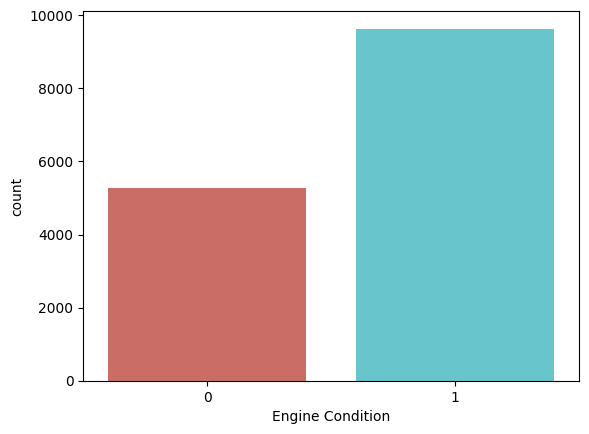

In [120]:
# Menampilkan nilai yang terdapat pada Engine Condition 

sns.countplot(x='Engine Condition', data = data, palette='hls')

In [121]:
# Menampilkan nilai rata-rata pada fitur berdasarkan Engine Condition

data.select_dtypes(include='number').groupby('Engine Condition').mean()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
Engine Condition,,,,,,
0,850.150237,3.225631,5.897846,2.214151,76.798960,78.649579
1,724.290118,3.360982,6.423713,2.203048,76.482012,78.068232


In [122]:
# Menentukan label target (Engine Condition)
if 'Engine Condition' in data.columns:
    target = 'Engine Condition'
else:
    raise ValueError("Kolom target 'Engine Condition' tidak ditemukan dalam dataset.")


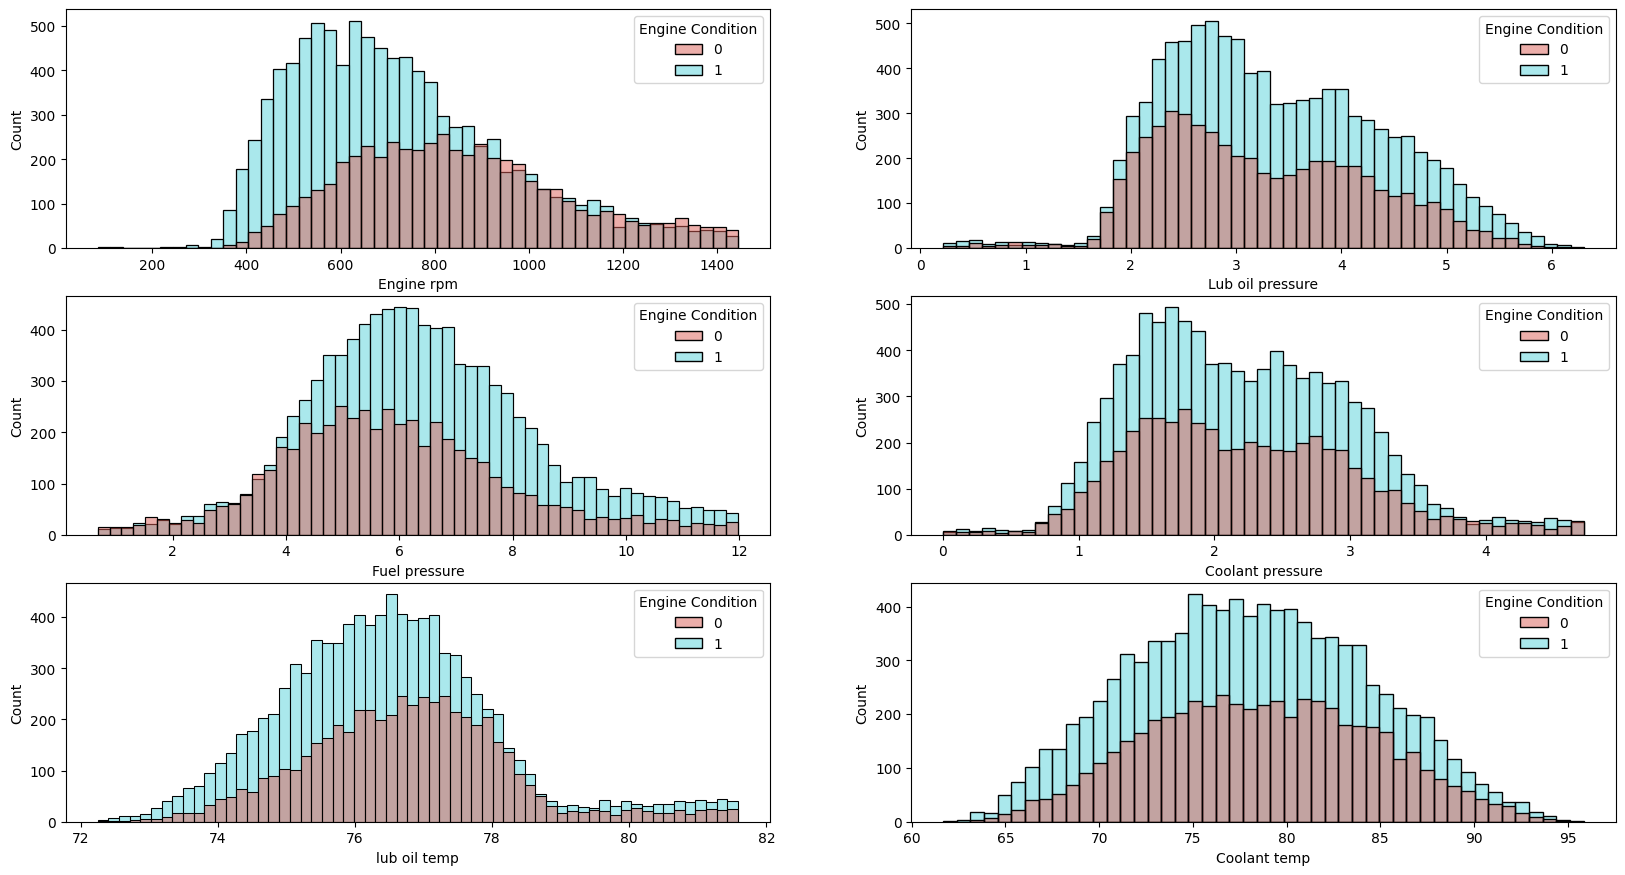

In [123]:
# Menampilkan jumlah instansi yang berlabel Engine Condition bermasalah atau tidak bermasalah pada setiap kolom fitur

plt.figure(figsize = (20, 18))
for i, col in enumerate(data.drop('Engine Condition', axis = 1).columns):
    plt.subplot(5, 2, i+1)
    sns.histplot(x = col, hue = 'Engine Condition', data = data, palette='hls')
plt.show()

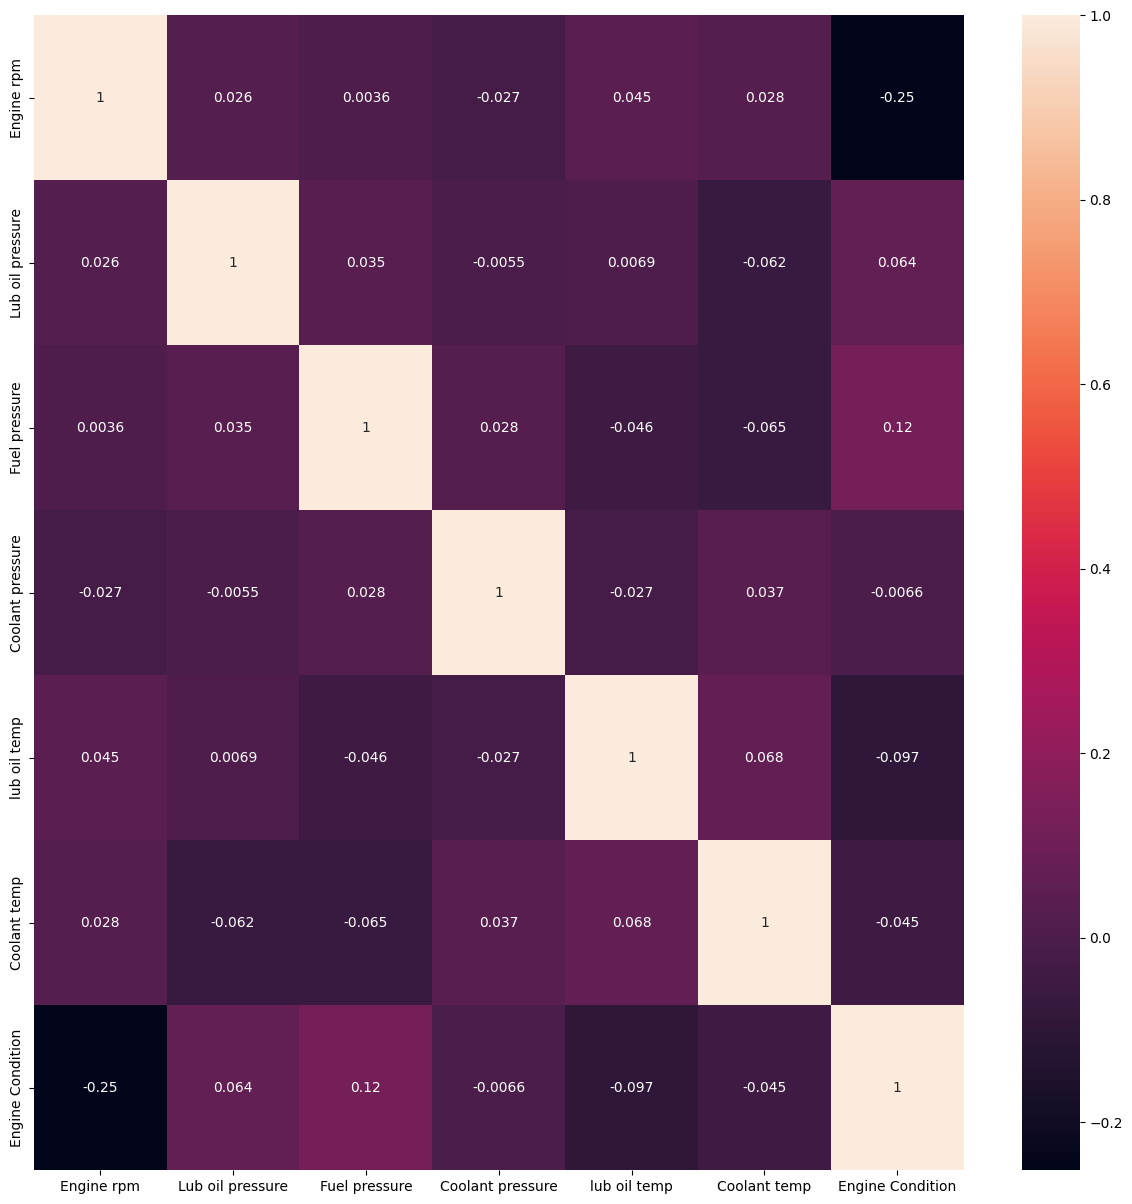

In [124]:
# Menampilkan korelasi antar fitur pada dataset

plt.figure(figsize=(15,15))
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True)
plt.show()

In [154]:
# 3. Preprocessing
# Handling missing values
data.fillna(data.median(), inplace=True)

C:\Users\Maarcellino\AppData\Local\Temp\ipykernel_7320\1300985231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(data.median(), inplace=True)


In [126]:
# Handling outliers dengan IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]


In [156]:
# Split Features dan Target
X = data.drop(columns=[target])
y = data[target]

## Balancing With SMOTE

In [15]:
# Imbalanced Data Handling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [13]:
data.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [143]:
# Standarisasi Data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

In [130]:
# Konversi kembali ke DataFrame setelah standarisasi
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

## Training

In [5]:
# Split Data untuk Training dan Testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

NameError: name 'X_resampled' is not defined

In [145]:
# 4. Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [164]:
# 5. Evaluasi Model
y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.34      0.39       956
           1       0.70      0.81      0.75      1838

    accuracy                           0.65      2794
   macro avg       0.59      0.57      0.57      2794
weighted avg       0.62      0.65      0.63      2794



In [165]:
# Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Accuracy: 0.66


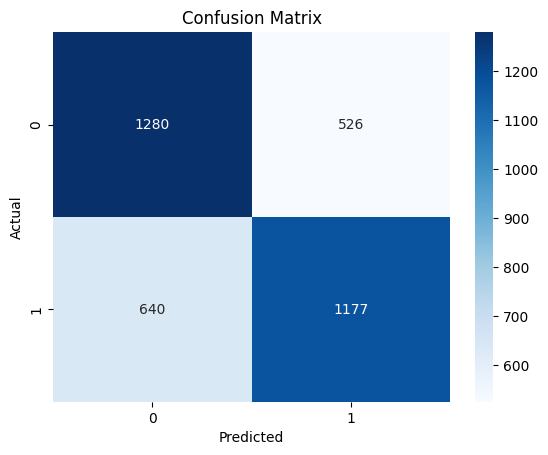

In [135]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC-AUC Score: 0.75


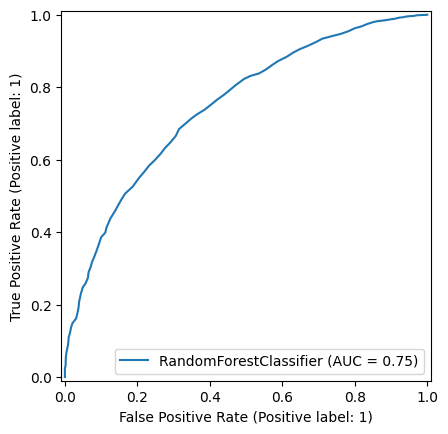

In [136]:
# ROC-AUC (untuk klasifikasi biner)
if len(y.unique()) == 2:  # Hanya untuk binary classification
    roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
    plt.show()

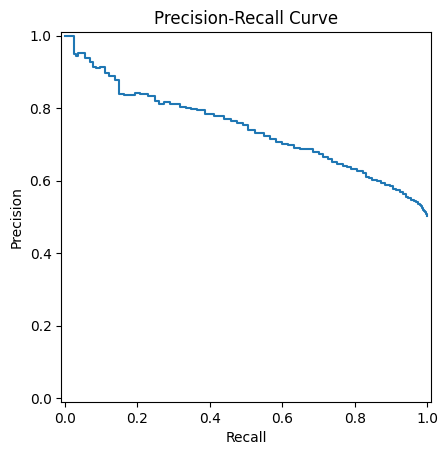

In [137]:

precision, recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.show()

In [138]:
# 6. Feature Importance Analysis
# Menggunakan Permutation Importance untuk faktor kunci
perm_importance = permutation_importance(rf_model, X_test, y_test, scoring='accuracy', random_state=42)
feature_importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
Engine rpm          0.117858
lub oil temp        0.051670
Fuel pressure       0.043776
Coolant temp        0.032073
Lub oil pressure    0.030914
Coolant pressure    0.018769
dtype: float64


## Feature Importance

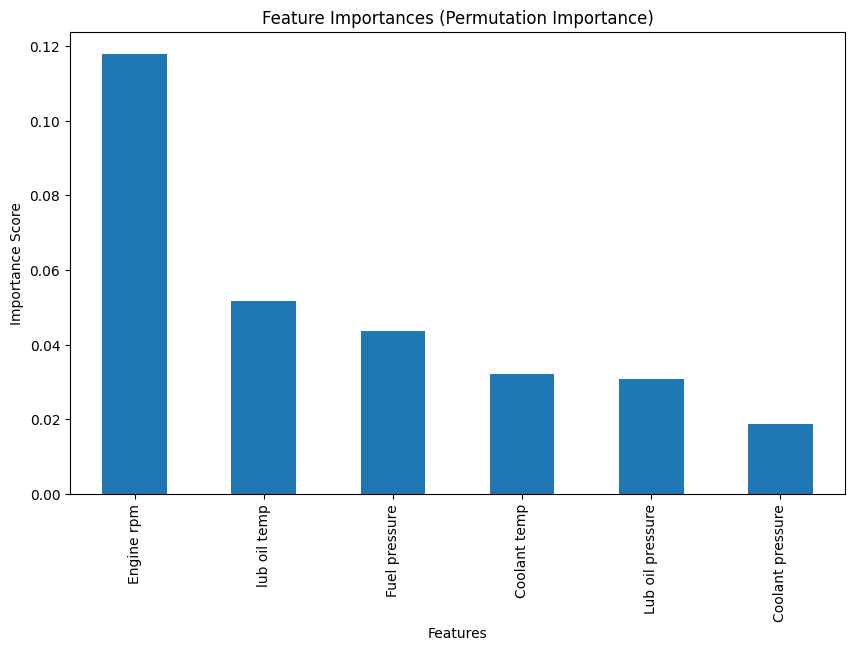

In [139]:
# Visualisasi Feature Importance
feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importances (Permutation Importance)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()



Feature Importances:
Engine rpm          0.222617
lub oil temp        0.163950
Fuel pressure       0.162263
Coolant temp        0.151927
Lub oil pressure    0.151788
Coolant pressure    0.147454
dtype: float64


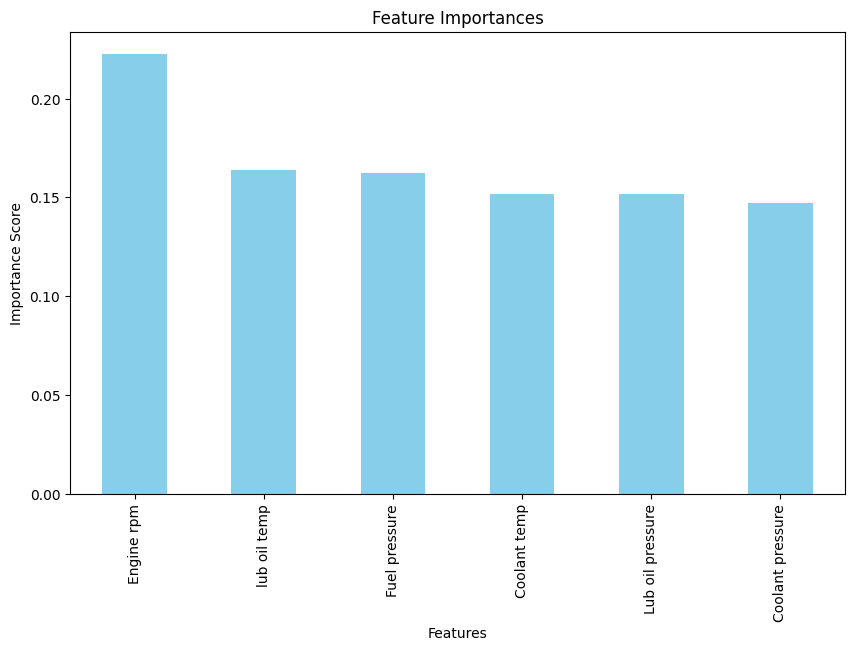

In [159]:
# Analisis Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

# Mendapatkan pentingnya fitur dari model Random Forest
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Menampilkan feature importance
print("\nFeature Importances:")
print(feature_importances)

# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


## Random Forest Modeling


Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.35      0.41      1416
           1       0.71      0.81      0.76      2775

    accuracy                           0.66      4191
   macro avg       0.60      0.58      0.58      4191
weighted avg       0.63      0.66      0.64      4191



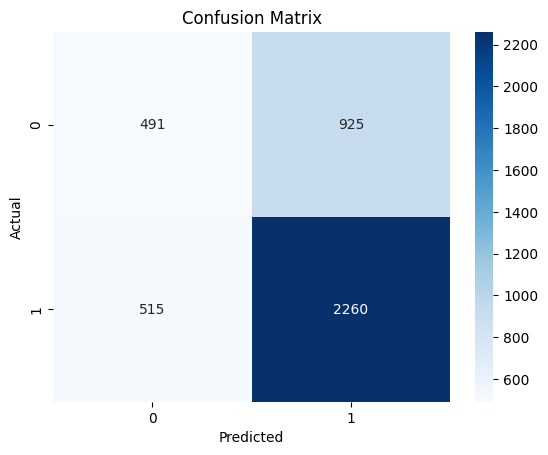

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pilih fitur penting berdasarkan hasil Feature Importance
selected_features = ['Engine rpm', 'lub oil temp', 'Fuel pressure', 
                     'Coolant temp', 'Lub oil pressure', 'Coolant pressure']

# Pisahkan Features (X) dan Target (y)
X = data[selected_features]  # Hanya fitur penting
y = data['Engine Condition']  # Target

# Split dataset menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inisialisasi dan train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
rf_model.fit(X_train, y_train)

# Prediksi pada data testing
y_pred = rf_model.predict(X_test)

# Evaluasi Model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [11]:
from sklearn.model_selection import train_test_split

# Pilih fitur penting berdasarkan hasil Feature Importance
selected_features = ['Engine rpm', 'lub oil temp', 'Fuel pressure', 
                     'Coolant temp', 'Lub oil pressure', 'Coolant pressure']

# Pisahkan Features (X) dan Target (y)
X = data[selected_features]
y = data['Engine Condition']

# Langkah 1: Split 70% Training dan 30% Testing+Validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Langkah 2: Split 30% menjadi 20% Testing dan 10% Validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42)

# Verifikasi Ukuran Setiap Split
print("Data Split Verification:")
print(f"Training set: {X_train.shape[0]} samples ({(X_train.shape[0] / len(X)) * 100:.2f}%)")
print(f"Testing set: {X_test.shape[0]} samples ({(X_test.shape[0] / len(X)) * 100:.2f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({(X_val.shape[0] / len(X)) * 100:.2f}%)")

# Output Sampel Data untuk Setiap Split
print("\nTraining Set Sample:")
print(X_train.head())
print("\nTesting Set Sample:")
print(X_test.head())
print("\nValidation Set Sample:")
print(X_val.head())


Data Split Verification:
Training set: 13674 samples (70.00%)
Testing set: 3907 samples (20.00%)
Validation set: 1954 samples (10.00%)

Training Set Sample:
       Engine rpm  lub oil temp  Fuel pressure  Coolant temp  \
12710         820     75.344219       3.519850     75.034982   
3763          484     75.227334       6.670412     71.518642   
79            795     76.284806       6.081633     68.683617   
4561          729     77.855398       6.335174     84.521636   
18341         499     75.903735       7.097337     76.584558   

       Lub oil pressure  Coolant pressure  
12710          3.608192          2.284361  
3763           2.828648          6.307960  
79             3.656956          4.643739  
4561           2.523225          2.078462  
18341          3.004559          1.478411  

Testing Set Sample:
       Engine rpm  lub oil temp  Fuel pressure  Coolant temp  \
2414          472     75.461990       4.768480     77.540134   
18481         951     76.748142       5.12585


Testing Set Evaluation:
Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.34      0.39       956
           1       0.70      0.81      0.75      1838

    accuracy                           0.65      2794
   macro avg       0.59      0.57      0.57      2794
weighted avg       0.62      0.65      0.63      2794



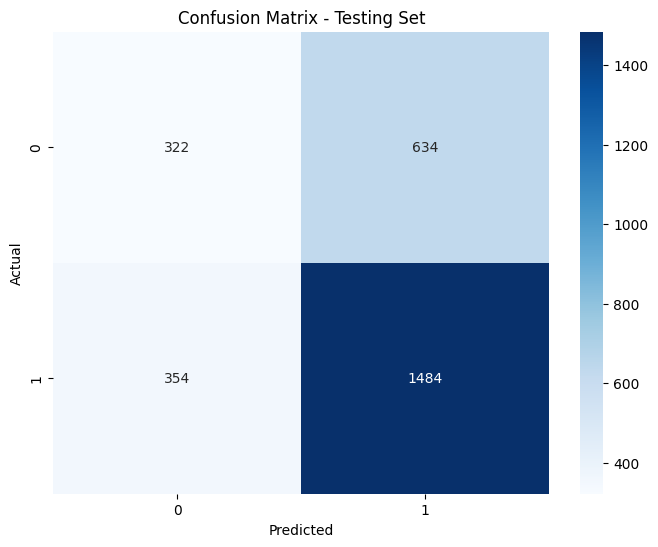


Validation Set Evaluation:
Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.37      0.43       460
           1       0.73      0.83      0.77       937

    accuracy                           0.68      1397
   macro avg       0.62      0.60      0.60      1397
weighted avg       0.66      0.68      0.66      1397



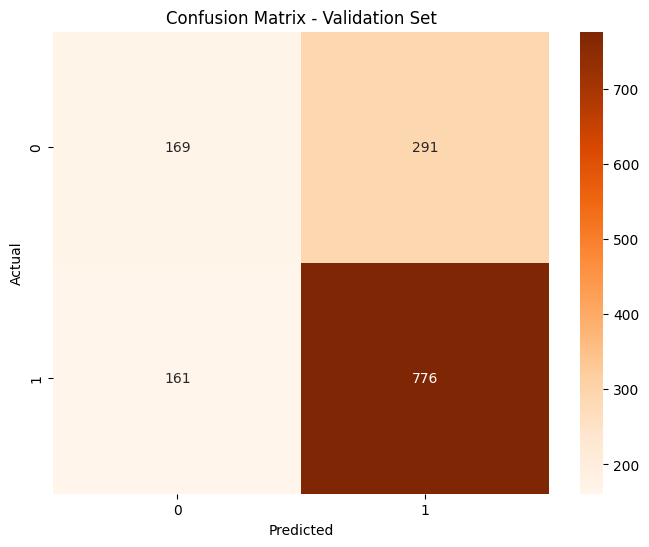

In [163]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
rf_model.fit(X_train, y_train)

# Evaluasi pada Testing Set
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTesting Set Evaluation:")
print(f"Accuracy: {test_accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix untuk Testing Set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Testing Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluasi pada Validation Set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("\nValidation Set Evaluation:")
print(f"Accuracy: {val_accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix untuk Validation Set
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [140]:
# 7. Simulasi Respons Waktu Nyata
# Mengambil satu sampel dari X_test
sample = X_test.sample(1, random_state=42)
sample_pred = rf_model.predict(sample)
sample_prob = rf_model.predict_proba(sample)

print("\nReal-Time Simulation:")
print(f"Input Sample:\n{sample}")
print(f"Predicted Condition: {sample_pred[0]}")
print(f"Prediction Probabilities: {sample_prob}")



Real-Time Simulation:
Input Sample:
      Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
7449    -1.14911         -0.851021        0.13714          0.155585   

      lub oil temp  Coolant temp  
7449     -1.530269      0.181485  
Predicted Condition: 1
Prediction Probabilities: [[0.21 0.79]]


In [141]:
# 8. Misclassification Analysis
misclassified = X_test[(y_test != y_pred)]
print(f"\nMisclassified Samples ({len(misclassified)} samples):")
print(misclassified)


Misclassified Samples (1166 samples):
       Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
16581   -0.485758          0.767715       0.458081         -0.622815   
4201     0.181846         -0.058883       0.124106          0.332522   
5541    -0.256137          2.434377       0.107133         -0.750503   
6051    -1.204389         -1.253855      -1.287897         -0.490433   
15303   -0.834443         -1.104811      -0.071774         -1.012334   
...           ...               ...            ...               ...   
12393   -0.468749          1.576097      -1.149514         -0.398941   
1547     0.645342         -1.949577      -0.107434         -1.128564   
2584    -1.204389          0.971656      -0.472210         -0.819571   
9199    -1.038551         -0.808314      -0.691377         -0.970094   
4254    -1.399993          0.702470      -0.782927         -0.689514   

       lub oil temp  Coolant temp  
16581     -1.109863     -0.252113  
4201       0.411209     

In [142]:
# 9. Simpulkan Hasil
print("\nKey Insights:")
print("- Akurasi Cross-Validation menunjukkan performa model.")
print("- Classification Report menunjukkan evaluasi terhadap target prediksi.")
print("- Feature Importance membantu memahami faktor kunci kerusakan kendaraan.")


Key Insights:
- Akurasi Cross-Validation menunjukkan performa model.
- Classification Report menunjukkan evaluasi terhadap target prediksi.
- Feature Importance membantu memahami faktor kunci kerusakan kendaraan.


In [8]:
# Ambil satu baris data dari testing set
single_sample = X_test.iloc[[0]]  # Pilih baris pertama, ubah index sesuai keperluan

# Lakukan prediksi
predicted_label = rf_model.predict(single_sample)
predicted_probability = rf_model.predict_proba(single_sample)

# Tampilkan hasil
print("Data Sampel:")
print(single_sample)
print("\nPrediksi Kondisi Mesin:", predicted_label[0])
print("Probabilitas Prediksi:", predicted_probability)


NameError: name 'X_test' is not defined